In [6]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import suncalc

import dask.dataframe as dd
from pathlib import Path
import glob
import re

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [7]:
import sys

sys.path.append("../src")
sys.path.append("../src/activity")

In [8]:
import subsampling as ss
import activity_assembly as actvt
import bout.assembly as bt
import comparison.data_assembly as comp
import comparison.plot as complot
from core import SITE_NAMES

from cli import get_file_paths
import plot
import pipeline

In [11]:
avail = np.arange(0, 720, 6) + 6
reset_24 = avail[np.where((24*60 % avail) == 0)[0]]

cycle_lengths = [6, 18, 30, 60, 120, 180]
percent_ons = [1/6, 1/3, 1/2, 2/3]
data_params = dict()
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
data_params['index_time_block_in_secs'] = '5'
dc_tags = ss.get_list_of_dc_tags(data_params["cycle_lengths"], data_params["percent_ons"])

site_keys = ['Carp', 'Telephone']
type_keys = ['LF', 'HF']
data_params["dc_tags"] = dc_tags
data_params['cur_dc_tag'] = '30of30'
data_params['metric_tag'] = 'call_rate'
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'
dt_starts = {'Carp':dt.datetime(2022, 8, 10, 0, 0, 0),
             'Telephone':dt.datetime(2022, 8, 19, 0, 0, 0)}
dt_ends = {'Carp':dt.datetime(2022, 8, 16, 16, 0, 0),
           'Telephone':dt.datetime(2022, 8, 25, 16, 0, 0)}

# for site_key in site_keys:
site_key = site_keys[0]
data_params['start'] = dt_starts[site_key]
data_params['end'] = dt_ends[site_key]
# for type_key in type_keys:
type_key = type_keys[0]
print(site_key, type_key)
data_params["site_tag"] = site_key
data_params["site_name"] = SITE_NAMES[site_key]
data_params["type_tag"] = type_key
file_paths = get_file_paths(data_params)

activity_arr = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths["dc_callrate_TYPE_SITE_summary"]}.csv', index_col=0)
callrate_arr = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths["cont_callrate_TYPE_SITE_summary"]}.csv', index_col=0)
activity_arr.index = pd.DatetimeIndex(activity_arr.index)
callrate_arr.index = pd.DatetimeIndex(callrate_arr.index)

Carp LF


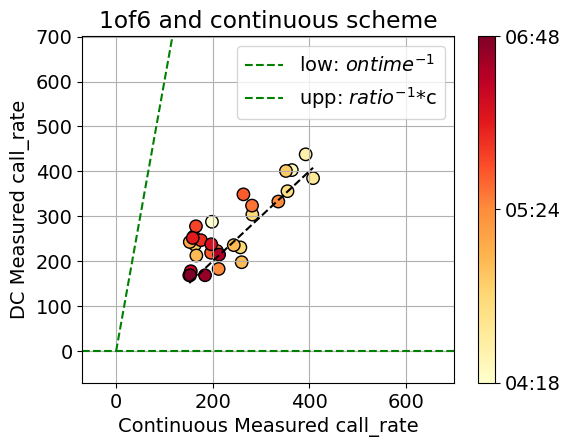

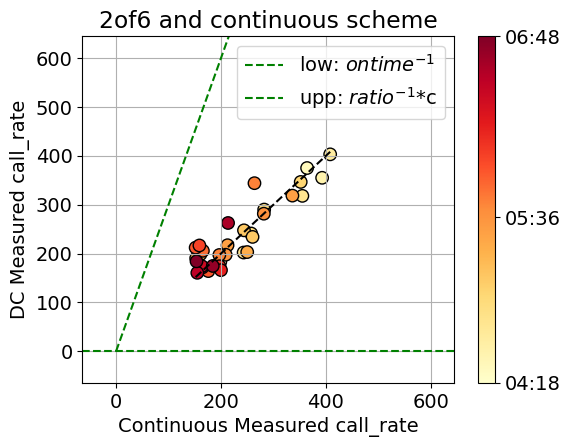

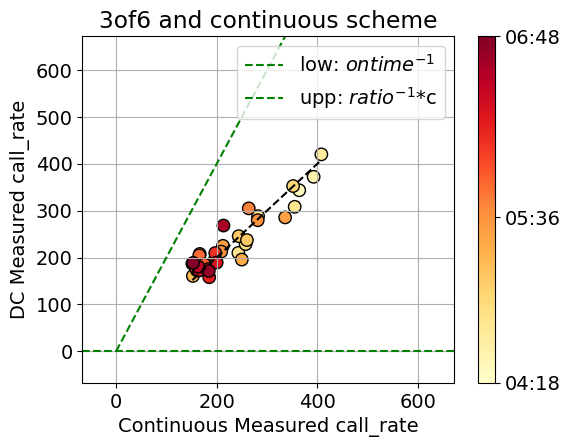

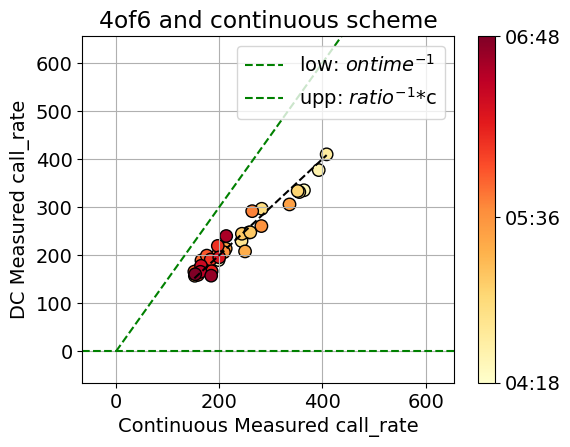

In [19]:
for tag in dc_tags[1:5]:
    plt.figure(figsize=(6, 4.5))
    plt.rcParams.update({'font.size':14})
    dc_col = tag
    dc_metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
    cycle_length = int(dc_col.split('of')[-1])
    cont_tag = f'{cycle_length}of{cycle_length}'

    cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
    callrate_cont_column = pd.DataFrame(callrate_arr.loc[:,cont_metric_col_name].dropna())
    metric_for_scheme = pd.DataFrame(activity_arr.loc[:,dc_metric_col_name].dropna())
    metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, callrate_cont_column)
    plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, callrate_cont_column, data_params)

    test_plc_metr = plt_cmetr[plt_cmetr>150].dropna()
    test_pldc_metr = plt_dcmetr.loc[test_plc_metr.index]
    test_pldc_metr = test_pldc_metr[test_pldc_metr>150]

    complot.plot_indiv_dc_control_comp_over_cycle_linear_scale(test_pldc_metr, test_plc_metr, data_params, drop_zero=True)

    plt.show()

In [ ]:

complot.plot_all_dc_scheme_comps_log_scale(activity_arr, callrate_arr, data_params)
complot.plot_all_dc_scheme_comps_linear_scale(activity_arr, callrate_arr, data_params)